In [1]:
import torch
from PIL import Image
from transformers import TableTransformerForObjectDetection
from transformers import AutoImageProcessor

c:\Users\antoi\Anaconda3\envs\candle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
path_image = r"D:\PycharmProjects\tableman\data\images\image_page_44.png"

In [6]:
image = Image.open(path_image).convert("RGB")

In [7]:
image.size

(2401, 1698)

In [8]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\antoi\Anaconda3\envs\candle\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [21]:
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection",
                                                               id2label={0: "Table"},
                                                               ignore_mismatched_sizes=True)


checkpoint = r"D:\PycharmProjects\candle\candleocr\checkpoints\table-detector_test_2_epoch=7.ckpt"
state_dict = torch.load(checkpoint)['state_dict']
try:
    model.load_state_dict(state_dict, strict=True)
except RuntimeError:
    for key in list(state_dict.keys()):
        # TODO find a way to generalized the change of layers name (or add new argument)
        # state_dict[key.replace('model.feature_extractor', 'backbone')] = state_dict.pop(key)
        if key in ["model.class_labels_classifier.weight", "model.class_labels_classifier.bias", "model.bbox_predictor.layers.0.weight", "model.bbox_predictor.layers.0.bias",
                    "model.bbox_predictor.layers.1.weight", "model.bbox_predictor.layers.1.bias", "model.bbox_predictor.layers.2.weight", "model.bbox_predictor.layers.2.bias"]:
            state_dict[key.replace("model.", "")] = state_dict.pop(key)
        else:
            state_dict[key.replace("model.model.", "model.")] = state_dict.pop(key)
model.load_state_dict(state_dict, strict=True)

Some weights of TableTransformerForObjectDetection were not initialized from the model checkpoint at microsoft/table-transformer-detection and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([3, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [22]:
inputs = image_processor(images=image, return_tensors="pt")

In [23]:
with torch.no_grad():
    outputs = model(**inputs)

In [26]:
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)

In [27]:
results

[{'scores': tensor([0.6359]),
  'labels': tensor([0]),
  'boxes': tensor([[1226.6394,  233.6728, 2338.1611, 1488.8213]])}]

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from torchvision.io import read_image

In [29]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [30]:
tensor_image = read_image(path_image)

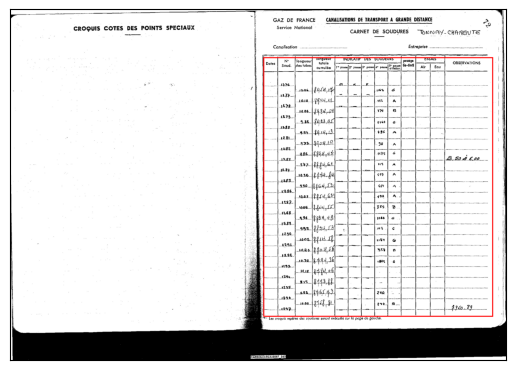

In [31]:

colors = "red"
result = draw_bounding_boxes(tensor_image, results[0]["boxes"], colors=colors, width=5)
show(result)